In [10]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize, curve_fit

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [11]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
abacus_particles = catalog_data.Data.load('/feynman/scratch/dphp/mp270220/abacus/AbacusSummit_2Gpc_z{:.3f}_ph000_downsampled_particles_nbar0.0034.npy'.format(z))
nbar = abacus_halos.size/(boxsize**3)

In [5]:
rng = np.random.RandomState(seed=0)
randoms_positions = np.array([rng.uniform(0., 1., abacus_halos.size)*b for b in (boxsize,)*3])

In [6]:
from pypower import CatalogMesh

halos_mesh = CatalogMesh(data_positions=abacus_halos.positions, interlacing=0,
                         boxsize=boxsize, boxcenter=boxcenter, resampler=resampler, cellsize=cellsize)

norm = abacus_halos.size
halos_painted_mesh = halos_mesh.to_mesh(field='data')
halos_density_mesh = halos_painted_mesh/(norm/(halos_mesh.nmesh[0]**3)) - 1
halos_densities = halos_density_mesh.readout(randoms_positions.T, resampler=resampler)

[000007.60]  03-25 13:30  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 27541685.
[000009.04]  03-25 13:30  CatalogMesh                  INFO     Painted 4194304 out of 27541685 objects to mesh.
[000009.04]  03-25 13:30  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 27541685.
[000010.35]  03-25 13:30  CatalogMesh                  INFO     Painted 8388608 out of 27541685 objects to mesh.
[000010.35]  03-25 13:30  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 27541685.
[000011.73]  03-25 13:30  CatalogMesh                  INFO     Painted 12582912 out of 27541685 objects to mesh.
[000011.73]  03-25 13:30  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 27541685.
[000013.02]  03-25 13:30  CatalogMesh                  INFO     Painted 16777216 out of 27541685 objects to mesh.
[000013.02]  03-25 13:30  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 27541685.
[000014.29]  03-25 13:31  CatalogMesh               

In [7]:
particles_mesh = CatalogMesh(data_positions=abacus_particles.positions, interlacing=0,
                             boxsize=boxsize, boxcenter=boxcenter, resampler=resampler, cellsize=cellsize)

norm = abacus_particles.size
particles_painted_mesh = particles_mesh.to_mesh(field='data')
particles_density_mesh = particles_painted_mesh/(norm/(particles_mesh.nmesh[0]**3)) - 1
particles_densities = particles_density_mesh.readout(randoms_positions.T, resampler=resampler)

fourier_density_mesh = particles_density_mesh.r2c()

[000026.51]  03-25 13:31  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 27542676.
[000027.92]  03-25 13:31  CatalogMesh                  INFO     Painted 4194304 out of 27542676 objects to mesh.
[000027.92]  03-25 13:31  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 27542676.
[000029.28]  03-25 13:31  CatalogMesh                  INFO     Painted 8388608 out of 27542676 objects to mesh.
[000029.28]  03-25 13:31  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 27542676.
[000030.62]  03-25 13:31  CatalogMesh                  INFO     Painted 12582912 out of 27542676 objects to mesh.
[000030.62]  03-25 13:31  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 27542676.
[000031.98]  03-25 13:31  CatalogMesh                  INFO     Painted 16777216 out of 27542676 objects to mesh.
[000031.98]  03-25 13:31  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 27542676.
[000033.37]  03-25 13:31  CatalogMesh               

In [8]:
def compute_tidal_field(fourier_delta_field, return_deriv=True):
    s = 0
    s_deriv = 0
    delta = fourier_delta_field.copy()
    k = fourier_delta_field.x
    k2 = sum(kk**2 for kk in k)
    mask_nonzero = k2 != 0.
    k2_nonzero = np.where(mask_nonzero, k2, 1)
    delta.value = np.where(mask_nonzero, fourier_delta_field.value, 0)
    for i, ki in enumerate(k):
        tmp = (ki**2/k2_nonzero - 1/3) * delta
        s += tmp.c2r()**2
        #s_deriv += tmp.c2r()**2
        for j, kj in enumerate(k):
            if j!=i:
                tmp = ki*kj/k2_nonzero * delta
                s += tmp.c2r()**2
    return s

particles_s2 = compute_tidal_field(fourier_density_mesh)

In [9]:
tidal_field_particles = particles_s2.readout(randoms_positions.T, resampler=resampler)

In [23]:
def bias_model(deltam, sm2=None, b1=1., b2=None, bs=None, b3=None):
    res = b1 * deltam
    if b2 is not None:
        deltam2 = np.mean(deltam**2)
        res += b2 * (deltam**2 - deltam2)
    if bs is not None and sm2 is not None:
        res += bs * (sm2 - np.mean(sm2))
    if b3 is not None:
        res += b3 * (deltam**3 - np.mean(deltam**3))
    return res

def fit_bias_params(deltam, deltah, b1init=1.5, order=3, sm2=None):
    x = deltah
    pdf1, bins1 = np.histogram(x, bins=200, density=True)

    def to_min(*params):
        y = bias_model(deltam, sm2, *params)
        pdf2 = np.histogram(y, bins=bins1, density=True)[0]
        return np.sum((pdf1-pdf2)**2)

    if order==1:
        x0 = np.array([b1init])
    if order==2:
        if sm2 is None:
            x0 = np.array([b1init, 0.])
        else:
            x0 = np.array([b1init, 0., 0.])
    if order==3:
        x0 = np.array([b1init, 0., 0., 0.])

    from iminuit import Minuit
    #res = minimize(to_min, x0=x0, tol=1e-3)
    m = Minuit(to_min, *x0)
    m.migrad()
    #imin = m.hesse()

    print(m)
    #return res.x
    return m

In [24]:
res1 = fit_bias_params(particles_densities, halos_densities, b1init=1.5, order=1, sm2=None)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03862                    │              Nfcn = 45               │
│ EDM = 3.09e-08 (Goal: 0.0002)    │           time = 82.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [29]:
res1.params['x0'].value

1.5289501966020824

In [ ]:
res2 = fit_bias_params(particles_densities, halos_densities, b1init=1.5, order=2, sm2=None)

In [31]:
res2

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03613                    │              Nfcn = 128              │
│ EDM = 5.35e-08 (Goal: 0.0002)    │           time = 250.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.53    │   0.04    │            │            │         │         │       │
│ 1 │ x1   │  0.0393   │  0.0016   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │  0.00132   9.2e-6 │
│ x1 │   9.2e-6 2.56e-06 │
└────┴───────────────────┘

In [34]:
res3 = fit_bias_params(particles_densities, halos_densities, b1init=1.5, order=2, sm2=tidal_field_particles)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03622                    │              Nfcn = 184              │
│ EDM = 0.000144 (Goal: 0.0002)    │           time = 385.6 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [35]:
res4 = fit_bias_params(particles_densities, halos_densities, b1init=1.5, order=3)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03108                    │              Nfcn = 355              │
│ EDM = 1.45e-08 (Goal: 0.0002)    │          time = 1652.2 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [36]:
res4

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.03108                    │              Nfcn = 355              │
│ EDM = 1.45e-08 (Goal: 0.0002)    │          time = 1652.2 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.5339   │  0.0000   │            │            │         │         │       │
│ 1 │ x1   │ 4.8699e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 2 │ x2   │     0     │     0     │            │            │         │         │       │
│ 3 │ x3   │-3.3094e-2 │ 0.0000e-2 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [37]:
bias_model1 = bias_model(particles_densities, sm2=None, b1=res1.params['x0'].value)
model1, delta1 = np.histogram(bias_model1, density=True, bins=200)

bias_model2 = bias_model(particles_densities, sm2=None, b1=res2.params['x0'].value, b2=res2.params['x1'].value)
model2, delta2 = np.histogram(bias_model2, density=True, bins=200)

bias_model3 = bias_model(particles_densities, sm2=tidal_field_particles, b1=res3.params['x0'].value, b2=res3.params['x1'].value, bs=res3.params['x2'].value)
model3, delta3 = np.histogram(bias_model3, density=True, bins=200)

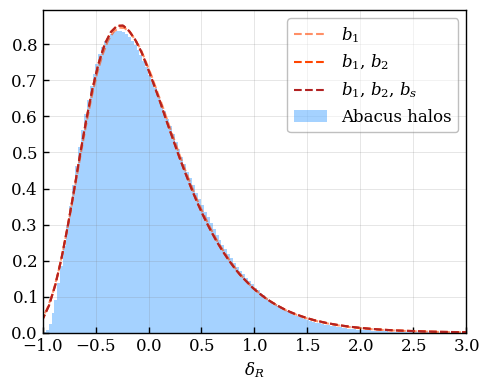

In [40]:
from matplotlib.colors import BoundaryNorm
cmap = plt.cm.cool

plt.plot((delta1[1:]+delta1[:-1])/2., model1, 'C1', ls='--', alpha=0.6, label=r'$b_1$')
plt.plot((delta2[1:]+delta2[:-1])/2., model2, 'C1', ls='--', alpha=1, label=r'$b_1$, $b_2$')
plt.plot((delta3[1:]+delta3[:-1])/2., model3, 'C3', ls='--', alpha=1, label=r'$b_1$, $b_2$, $b_s$')
plt.hist(halos_densities, bins=200, density=True, alpha=0.4, color='C0', label=r'Abacus halos')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.savefig('../../plots/density_bias_model.png')
plt.show()